In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt 
from scipy import stats

In [14]:
zri_acs_bs = pd.read_csv('../data/zri_acs_bikeshare_merged.csv')
zri_acs_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93672 entries, 0 to 93671
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   zip                               93672 non-null  int64  
 1   zri                               93672 non-null  float64
 2   year                              93672 non-null  int64  
 3   month                             93672 non-null  int64  
 4   datetime                          93672 non-null  object 
 5   percent_white                     93672 non-null  float64
 6   percent_black                     93672 non-null  float64
 7   percent_asian                     93672 non-null  float64
 8   percent_hispanic                  93672 non-null  float64
 9   percent_native_am                 93672 non-null  float64
 10  percent_other_race                93672 non-null  float64
 11  percent_0_17                      93672 non-null  float64
 12  perc

In [15]:
zri_acs_bs['zip'] = zri_acs_bs['zip'].astype('string')
zri_acs_bs['zip'] = ["0"+z if len(z)<5 else z for z in zri_acs_bs['zip']]

In [18]:
zri_acs_bs

,zip,zri,year,month,datetime,percent_white,percent_black,percent_asian,percent_hispanic,percent_native_am,...,total_pop,percent_workforce_unemployed,percent_work_from_home,median_age,percent_female,gini_index,percent_not_us_citizen,bs_total_stations,bs_total_systems,has_bike_sharing
0,01013,928.0,2014,1,2014-01-01,0.728315,0.020951,0.013732,0.219830,0.000000,...,22343.583333,0.104130,0.009346,36.416667,0.509533,0.420742,0.056062,0.0,0.0,0
1,01013,931.0,2014,2,2014-02-01,0.727052,0.021179,0.013708,0.220867,0.000000,...,22296.166667,0.104147,0.009839,36.433333,0.508816,0.420483,0.056165,0.0,0.0,0
2,01013,934.0,2014,3,2014-03-01,0.725788,0.021408,0.013685,0.221904,0.000000,...,22248.750000,0.104165,0.010332,36.450000,0.508100,0.420225,0.056267,0.0,0.0,0
3,01013,929.0,2014,4,2014-04-01,0.724525,0.021636,0.013661,0.222940,0.000000,...,22201.333333,0.104182,0.010825,36.466667,0.507383,0.419967,0.056370,0.0,0.0,0
4,01013,929.0,2014,5,2014-05-01,0.723261,0.021864,0.013638,0.223977,0.000000,...,22153.916667,0.104199,0.011318,36.483333,0.506666,0.419708,0.056472,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93667,99654,1277.0,2019,8,2019-08-01,0.796036,0.008872,0.014941,0.049974,0.049727,...,60057.000000,0.102326,0.049199,33.566667,0.475244,0.399400,0.018076,0.0,0.0,0
93668,99654,1271.0,2019,9,2019-09-01,0.795709,0.008765,0.014871,0.050125,0.049560,...,60203.000000,0.102254,0.049419,33.575000,0.475511,0.399650,0.018306,0.0,0.0,0
93669,99654,1299.0,2019,10,2019-10-01,0.795381,0.008658,0.014801,0.050275,0.049393,...,60349.000000,0.102181,0.049640,33.583333,0.475778,0.399900,0.018537,0.0,0.0,0
93670,99654,1261.5,2019,11,2019-11-01,0.795054,0.008550,0.014730,0.050426,0.049226,...,60495.000000,0.102109,0.049861,33.591667,0.476045,0.400150,0.018767,0.0,0.0,0


In [49]:
def laggenerator(i,colname,df):
    timelist=list(df['year-month'].drop_duplicates().sort_values())[0:i]
    
    df.loc[:,f'{colname}_lag{i}']=df.loc[:,f'{colname}'].shift(i)
    
    df.loc[df['year-month'].isin(timelist),f'{colname}_lag{i}']=0
    return df

# 1. LASSO only on Autoregressive (Rent index) 

In [56]:
zri = pd.read_csv('../data/zri_multifamily_v2.csv')
zri['zip'] = zri['zip'].astype('string')
zri['zip'] = ["0"+z if len(z)<5 else z for z in zri['zip']]
zri['year'] = pd.to_datetime(zri['year-month'],format="%Y-%m").dt.year
zri['year-month'] = pd.to_datetime(zri['year-month'],format="%Y-%m")
zri = zri.drop(index=zri[zri['zip']=="11249"].index)

In [57]:
zri_lags = zri.copy()
for i in range(1,4):
    zri_lags =laggenerator(i, 'zri',zri_lags)


In [58]:
zri_lags

,zip,City,State,Metro,CountyName,year-month,zri,year,zri_lag1,zri_lag2,zri_lag3
0,01013,Chicopee,MA,Springfield,Hampden County,2014-01-01,928.0,2014,0.0,0.0,0.0
1,01013,Chicopee,MA,Springfield,Hampden County,2014-02-01,931.0,2014,928.0,0.0,0.0
2,01013,Chicopee,MA,Springfield,Hampden County,2014-03-01,934.0,2014,931.0,928.0,0.0
3,01013,Chicopee,MA,Springfield,Hampden County,2014-04-01,929.0,2014,934.0,931.0,928.0
4,01013,Chicopee,MA,Springfield,Hampden County,2014-05-01,929.0,2014,929.0,934.0,931.0
...,...,...,...,...,...,...,...,...,...,...,...
93739,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-08-01,1277.0,2019,1291.0,1294.0,1296.0
93740,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-09-01,1271.0,2019,1277.0,1291.0,1294.0
93741,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-10-01,1299.0,2019,1271.0,1277.0,1291.0
93742,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-11-01,1261.5,2019,1299.0,1271.0,1277.0


In [59]:
train = zri_lags[zri_lags['year'] < 2019]
test = zri_lags[zri_lags['year']==2019]
train = train.drop(['year'],axis=1)
test = test.drop(['year'],axis=1)

In [60]:
train_y = train['zri']
train_X = train.drop(['zri'],axis=1)

test_y = test['zri']
test_X = test.drop(['zri'],axis=1)

In [63]:
train_X

,zip,City,State,Metro,CountyName,year-month,zri_lag1,zri_lag2,zri_lag3
0,01013,Chicopee,MA,Springfield,Hampden County,2014-01-01,0.0,0.0,0.0
1,01013,Chicopee,MA,Springfield,Hampden County,2014-02-01,928.0,0.0,0.0
2,01013,Chicopee,MA,Springfield,Hampden County,2014-03-01,931.0,928.0,0.0
3,01013,Chicopee,MA,Springfield,Hampden County,2014-04-01,934.0,931.0,928.0
4,01013,Chicopee,MA,Springfield,Hampden County,2014-05-01,929.0,934.0,931.0
...,...,...,...,...,...,...,...,...,...
93727,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2018-08-01,1332.0,1334.0,1335.0
93728,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2018-09-01,1337.0,1332.0,1334.0
93729,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2018-10-01,1337.0,1337.0,1332.0
93730,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2018-11-01,1335.0,1337.0,1337.0


# Just zri_lag1, zri_lag2, zri_lag3 (no city, state, metro, county, year-month encoding) 

In [98]:
cols = ['zip','zri_lag1','zri_lag2','zri_lag3']
train_X_1 = train_X[cols]
test_X_1 = test_X[['zip','zri_lag1','zri_lag2','zri_lag3']]

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [76]:
#1. Label encode zip
le = LabelEncoder()
train_X_1.loc[:,'zip'] = le.fit_transform(train_X_1.loc[:,'zip'])
test_X_1.loc[:,'zip'] = le.transform(test_X_1.loc[:,'zip'])

In [80]:
#2. Standard Scaler to all data 
scaler = StandardScaler()
train_X_1_scaled = scaler.fit_transform(train_X_1)
test_X_1_scaled = scaler.transform(test_X_1)

In [81]:
#3. Lasso Grid Search
lasso = Lasso()
grid = dict()
grid['alpha'] = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
lasso_grid = GridSearchCV(lasso, grid, cv=5, n_jobs=-1).fit(train_X_1_scaled,train_y)
lasso_best = lasso_grid.best_estimator_

In [96]:
print(f'lasso_best : {lasso_best}')
lasso_best.fit(train_X_1_scaled, train_y)
print('LASSO')
print(f'R2: {lasso_best.score(test_X_1_scaled,test_y)}')
print(f'RMSE: {sqrt(mean_squared_error(lasso_best.predict(test_X_1_scaled),test_y))}')


lasso_best : Lasso(alpha=10)
LASSO
R2: 0.9907254530402929
RMSE: 64.07234255283224


In [102]:
importance = np.abs(lasso_best.coef_)
coef = lasso_best.coef_
feature_names = np.array(cols)
feature_importances= pd.DataFrame([feature_names,importance,coef]).T
feature_importances.columns = ['feature_names','coef_abs','coef']

feature_importances = feature_importances.sort_values(by='coef_abs',ascending=False)
#feature_importances[feature_importances['coef_abs']>0]
feature_importances

,feature_names,coef_abs,coef
1,zri_lag1,618.524547,618.524547
3,zri_lag3,1.680364,1.680364
0,zip,0.0,-0.0
2,zri_lag2,0.0,0.0


# zri_lag1, zri_lag2, zri_lag3 and encoding for city, state, metro, county

In [112]:
cols = ['zip', 'City', 'State', 'Metro', 'CountyName','zri_lag1','zri_lag2', 'zri_lag3']
train_X_2 = train_X[cols]
test_X_2 = test_X[cols]

In [114]:
#1. Label encode zip, city, state, metro, countyname, year-month 
le1 = LabelEncoder()
train_X_2.loc[:,'zip'] = le1.fit_transform(train_X_2.loc[:,'zip'])
test_X_2.loc[:,'zip'] = le1.transform(test_X_2.loc[:,'zip'])

le2 = LabelEncoder()
train_X_2.loc[:,'City'] = le2.fit_transform(train_X_2.loc[:,'City'])
test_X_2.loc[:,'City'] = le2.transform(test_X_2.loc[:,'City'])

le3 = LabelEncoder()
train_X_2.loc[:,'State'] = le3.fit_transform(train_X_2.loc[:,'State'])
test_X_2.loc[:,'State'] = le3.transform(test_X_2.loc[:,'State'])

le4 = LabelEncoder()
train_X_2.loc[:,'Metro'] = le4.fit_transform(train_X_2.loc[:,'Metro'])
test_X_2.loc[:,'Metro'] = le4.transform(test_X_2.loc[:,'Metro'])

le5 = LabelEncoder()
train_X_2.loc[:,'CountyName'] = le5.fit_transform(train_X_2.loc[:,'CountyName'])
test_X_2.loc[:,'CountyName'] = le5.transform(test_X_2.loc[:,'CountyName'])

In [118]:
#2. Standard Scaler to all data 
scaler = StandardScaler()
train_X_2_scaled = scaler.fit_transform(train_X_2)
test_X_2_scaled = scaler.transform(test_X_2)

In [119]:
#3. Lasso Grid Search
lasso = Lasso()
grid = dict()
grid['alpha'] = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
lasso_grid = GridSearchCV(lasso, grid, cv=5, n_jobs=-1).fit(train_X_2_scaled,train_y)
lasso_best = lasso_grid.best_estimator_

In [120]:
print(f'lasso_best : {lasso_best}')
lasso_best.fit(train_X_2_scaled, train_y)
print('LASSO')
print(f'R2: {lasso_best.score(test_X_2_scaled,test_y)}')
print(f'RMSE: {sqrt(mean_squared_error(lasso_best.predict(test_X_2_scaled),test_y))}')


lasso_best : Lasso(alpha=10)
LASSO
R2: 0.9907032952782536
RMSE: 64.14883430969256


In [121]:
importance = np.abs(lasso_best.coef_)
coef = lasso_best.coef_
feature_names = np.array(cols)
feature_importances= pd.DataFrame([feature_names,importance,coef]).T
feature_importances.columns = ['feature_names','coef_abs','coef']

feature_importances = feature_importances.sort_values(by='coef_abs',ascending=False)
#feature_importances[feature_importances['coef_abs']>0]
feature_importances

,feature_names,coef_abs,coef
5,zri_lag1,615.625118,615.625118
2,State,7.433775,-7.433775
4,CountyName,3.568662,3.568662
7,zri_lag3,2.273785,2.273785
0,zip,0.0,-0.0
1,City,0.0,0.0
3,Metro,0.0,0.0
6,zri_lag2,0.0,0.0


In [ ]:
lasso = Lasso()
grid = dict()
grid['alpha'] = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
lasso_grid = GridSearchCV(lasso, grid, cv=5, n_jobs=-1).fit(train_X_scaled,train_y)
lasso_best = lasso_grid.best_estimator_
lasso_best.fit(train_X_scaled, train_y)
lasso_best.fit(train_X_scaled, train_y)
print('LASSO')
print(f'R2: {lasso_best.score(test_X_scaled,test_y)}')
print(f'RMSE: {sqrt(mean_squared_error(lasso_best.predict(test_X_scaled),test_y))}')

importance = np.abs(lasso_best.coef_)
coef = lasso_best.coef_
feature_names = np.array(train_X.columns.to_list())
feature_importances= pd.DataFrame([feature_names,importance,coef]).T
feature_importances.columns = ['feature_names','coef_abs','coef']

feature_importances = feature_importances.sort_values(by='coef_abs',ascending=False)
feature_importances[feature_importances['coef_abs']>0]

sfm = SelectFromModel(lasso).fit(train_X_scaled, train_y)
print("Features selected by SelectFromModel: \n"
      f"{feature_names[sfm.get_support()]}")

# Add lagged columns
- ZRI lags: last 3 months
- ACS lags: 12 months before, 24 months before

In [16]:
def laggenerator(i,colname,df):
    timelist=list(df['year-month'].drop_duplicates().sort_values())[0:i]
    
    df.loc[:,f'{colname}_lag{i}']=df.loc[:,f'{colname}'].shift(i)
    
    df.loc[df['year-month'].isin(timelist),f'{colname}_lag{i}']=0
    return df

In [ ]:
# zri_acs_bs_lags = zri_acs_bs.copy()
# for i in range(1,4):
#     zillow_lags=laggenerator(i, 'zri',zri_acs_bs_lags)

# Load Data (ZRI, ACS) 

In [ ]:
zri_cols = 

In [175]:
zri = pd.read_csv('../data/zri_multifamily_v2.csv')
zri['zip'] = zri['zip'].astype('string')
zri['zip'] = ["0"+z if len(z)<5 else z for z in zri['zip']]
zri['year'] = pd.to_datetime(zri['year-month'],format="%Y-%m").dt.year
zri['year'] = zri['year'].astype('string')
zri['year-month'] = pd.to_datetime(zri['year-month'],format="%Y-%m")
zri = zri.drop(index=zri[zri['zip']=="11249"].index)

In [176]:
acs = pd.read_csv('../data/acs_engineered_features.csv')
acs['zip'] = acs['zip'].astype('string')
acs['zip'] = ["0"+z if len(z)<5 else z for z in acs['zip']]
acs['year_usable'] = acs['year_usable'].astype('string')

#  ZRI Data - target variable - zscore(zri), log(zri) 

<AxesSubplot:>

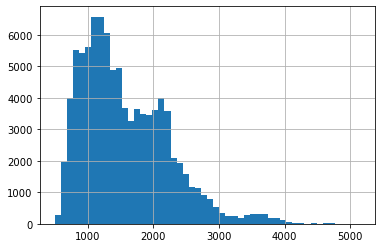

In [159]:
zri['zri'].hist(bins=50)

<AxesSubplot:>

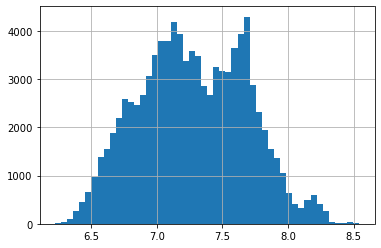

In [160]:
np.log(zri['zri']).hist(bins=50)

In [161]:
pd.Series(stats.zscore(zri[zri['zip']=='07302']['zri']))

0    -1.985107
1    -1.985107
2    -2.074549
3    -2.098942
4    -2.025762
        ...   
67    1.454330
68    1.576296
69    1.625082
70    1.673868
71    1.673868
Length: 72, dtype: float64

In [162]:
zri[zri['zip']=='07302']['zri']

14256    2135.0
14257    2135.0
14258    2124.0
14259    2121.0
14260    2130.0
          ...  
14323    2558.0
14324    2573.0
14325    2579.0
14326    2585.0
14327    2585.0
Name: zri, Length: 72, dtype: float64

In [163]:
zri['zri_zscore'] = zri['zri']

In [164]:
for z in zri['zip'].unique():
    zri.loc[zri['zip']==z,'zri_zscore'] = stats.zscore(zri.loc[zri['zip']==z,'zri'])

<AxesSubplot:>

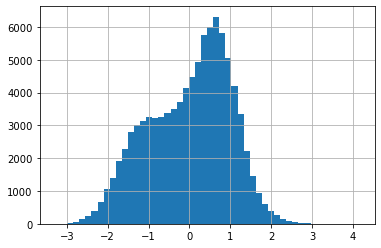

In [165]:
zri['zri_zscore'].hist(bins=50)

<AxesSubplot:>

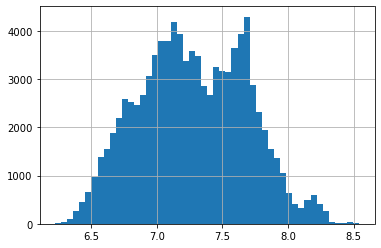

In [166]:
np.log(zri['zri']).hist(bins=50)

In [177]:
zillow = zri[['zip','City','State','year-month','year','zri']]

In [178]:
zillow

,zip,City,State,year-month,year,zri
0,01013,Chicopee,MA,2014-01-01,2014,928.0
1,01013,Chicopee,MA,2014-02-01,2014,931.0
2,01013,Chicopee,MA,2014-03-01,2014,934.0
3,01013,Chicopee,MA,2014-04-01,2014,929.0
4,01013,Chicopee,MA,2014-05-01,2014,929.0
...,...,...,...,...,...,...
93739,99654,Wasilla,AK,2019-08-01,2019,1277.0
93740,99654,Wasilla,AK,2019-09-01,2019,1271.0
93741,99654,Wasilla,AK,2019-10-01,2019,1299.0
93742,99654,Wasilla,AK,2019-11-01,2019,1261.5


# Add lagged columns
- ZRI lags: last 3 months
- ACS lags: 12 months before, 24 months before 

In [179]:
# zillow_lags = pd.DataFrame()
# for z in zillow['zip'].unique():
#     data_temp = zillow[zillow['zip']==z]
#     data_temp.loc[:,'zri_lag_1']= data_temp.loc[:,'zri'].shift(+1)
#     data_temp.loc[:,'zri_lag_2']= data_temp.loc[:,'zri'].shift(+2)
#     data_temp.loc[:,'zri_lag_3']= data_temp.loc[:,'zri'].shift(+3)
#     zillow_lags = zillow_lags.append(data_temp)
# zillow_lags[zillow_lags.isna().any(axis=1)]

In [180]:
def laggenerator(i,colname,df):
    timelist=list(df['year-month'].drop_duplicates().sort_values())[0:i]
    
    df.loc[:,f'{colname}_lag{i}']=df.loc[:,f'{colname}'].shift(i)
    
    df.loc[df['year-month'].isin(timelist),f'{colname}_lag{i}']=0
    return df

In [185]:
zillow_lags = zillow.copy()
for i in range(1,4):
    zillow_lags=laggenerator(i, 'zri',zillow_lags)

In [186]:
zillow_lags

,zip,City,State,year-month,year,zri,zri_lag1,zri_lag2,zri_lag3
0,01013,Chicopee,MA,2014-01-01,2014,928.0,0.0,0.0,0.0
1,01013,Chicopee,MA,2014-02-01,2014,931.0,928.0,0.0,0.0
2,01013,Chicopee,MA,2014-03-01,2014,934.0,931.0,928.0,0.0
3,01013,Chicopee,MA,2014-04-01,2014,929.0,934.0,931.0,928.0
4,01013,Chicopee,MA,2014-05-01,2014,929.0,929.0,934.0,931.0
...,...,...,...,...,...,...,...,...,...
93739,99654,Wasilla,AK,2019-08-01,2019,1277.0,1291.0,1294.0,1296.0
93740,99654,Wasilla,AK,2019-09-01,2019,1271.0,1277.0,1291.0,1294.0
93741,99654,Wasilla,AK,2019-10-01,2019,1299.0,1271.0,1277.0,1291.0
93742,99654,Wasilla,AK,2019-11-01,2019,1261.5,1299.0,1271.0,1277.0


In [188]:
acs

,zip,census_period,year_usable,percent_white,percent_black,percent_asian,percent_hispanic,percent_native_am,percent_other_race,percent_0_17,...,median_building_age,income_per_capita,poverty_rate,total_pop,percent_workforce_unemployed,percent_work_from_home,median_age,percent_female,gini_index,percent_not_us_citizen
0,01013,20072011,2013,0.729579,0.020723,0.013756,0.218793,0.000000,0.005002,0.230494,...,62.0,20433.0,0.190522,22391,0.104113,0.008853,36.4,0.510250,0.4210,0.055960
1,01013,20082012,2014,0.714417,0.023463,0.013473,0.231235,0.000000,0.004491,0.224682,...,62.0,20940.0,0.201543,21822,0.104320,0.014770,36.6,0.501650,0.4179,0.057190
2,01013,20092013,2015,0.720119,0.027857,0.016777,0.217971,0.001357,0.005065,0.217248,...,66.0,20889.0,0.173591,22113,0.113411,0.012946,35.5,0.506851,0.4110,0.056483
3,01013,20102014,2016,0.713799,0.017445,0.016638,0.237499,0.000538,0.002197,0.221131,...,72.0,21371.0,0.155696,22299,0.115569,0.013701,35.8,0.512669,0.4061,0.050182
4,01013,20112015,2017,0.703894,0.022238,0.018442,0.241627,0.001116,0.001652,0.222336,...,73.0,21477.0,0.169816,22394,0.114075,0.020243,34.9,0.514200,0.4117,0.050013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92647,99901,20092013,2015,0.653872,0.002271,0.063146,0.044026,0.142407,0.002710,0.233756,...,38.0,31563.0,0.101846,13651,0.086316,0.021073,38.7,0.478353,0.3981,0.025493
92648,99901,20102014,2016,0.654374,0.004016,0.061487,0.046444,0.143932,0.000000,0.232584,...,38.0,31487.0,0.114447,13694,0.085095,0.022509,38.8,0.481233,0.4057,0.023952
92649,99901,20112015,2017,0.649705,0.004228,0.073631,0.048334,0.135379,0.001604,0.230079,...,40.0,32010.0,0.121194,13717,0.078951,0.023050,38.7,0.485602,0.4110,0.025953
92650,99901,20122016,2018,0.645762,0.004947,0.076319,0.046126,0.129138,0.005384,0.225609,...,40.0,32671.0,0.108124,13745,0.075428,0.026582,39.2,0.485922,0.4158,0.035504


In [226]:
merged = pd.merge(zillow_lags,acs,how='left',left_on=["zip","year"],right_on=["zip","year_usable"])
#merged.head(36)[['zip','City','year-month','year','percent_white']]

In [229]:
acs_lags = merged.copy()

In [230]:
acs_cols = ['percent_white',
       'percent_black', 'percent_asian', 'percent_hispanic',
       'percent_native_am', 'percent_other_race', 'percent_0_17',
       'percent_18_39', 'percent_40_64', 'percent_65+',
       'percent_rental_units_vacant', 'percent_rental_units_occupied',
       'percent_graduate_deg', 'percent_bachelors', 'percent_associates',
       'percent_highschool', 'percent_less_highschool',
       'percent_commute_public_transport', 'percent_commute_less_30',
       'percent_commute_30_to_59', 'percent_commute_60_to_89',
       'percent_commute_90_more', 'percent_new_city', 'percent_new_unit',
       'percent_units_owner_occupied', 'median_building_age',
       'income_per_capita', 'poverty_rate', 'total_pop',
       'percent_workforce_unemployed', 'percent_work_from_home', 'median_age',
       'percent_female', 'gini_index', 'percent_not_us_citizen']


for col in acs_cols:
    for i in [12,24]:
        acs_lags=laggenerator(i,col,acs_lags)

In [233]:
acs_lags.tail()

,zip,City,State,year-month,year,zri,zri_lag1,zri_lag2,zri_lag3,census_period,...,percent_work_from_home_lag12,percent_work_from_home_lag24,median_age_lag12,median_age_lag24,percent_female_lag12,percent_female_lag24,gini_index_lag12,gini_index_lag24,percent_not_us_citizen_lag12,percent_not_us_citizen_lag24
93667,99654,Wasilla,AK,2019-08-01,2019,1277.0,1291.0,1294.0,1296.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725
93668,99654,Wasilla,AK,2019-09-01,2019,1271.0,1277.0,1291.0,1294.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725
93669,99654,Wasilla,AK,2019-10-01,2019,1299.0,1271.0,1277.0,1291.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725
93670,99654,Wasilla,AK,2019-11-01,2019,1261.5,1299.0,1271.0,1277.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725
93671,99654,Wasilla,AK,2019-12-01,2019,1224.0,1261.5,1299.0,1271.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725


# Split train and test

In [298]:
acs_lags['year'] = acs_lags['year'].astype(int)

In [299]:
train = acs_lags[acs_lags['year'] < 2019]
test = acs_lags[acs_lags['year']==2019]

In [300]:
train_y = train['zri']
train_X = train.drop(['zri','year-month','year','census_period','year_usable'],axis=1)

test_y = test['zri']
test_X = test.drop(['zri','year-month','year','census_period','year_usable'],axis=1)

In [301]:
train_X

,zip,City,State,zri_lag1,zri_lag2,zri_lag3,percent_white,percent_black,percent_asian,percent_hispanic,...,percent_work_from_home_lag12,percent_work_from_home_lag24,median_age_lag12,median_age_lag24,percent_female_lag12,percent_female_lag24,gini_index_lag12,gini_index_lag24,percent_not_us_citizen_lag12,percent_not_us_citizen_lag24
0,01013,Chicopee,MA,0.0,0.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
1,01013,Chicopee,MA,928.0,0.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
2,01013,Chicopee,MA,931.0,928.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
3,01013,Chicopee,MA,934.0,931.0,928.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
4,01013,Chicopee,MA,929.0,934.0,931.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93655,99654,Wasilla,AK,1332.0,1334.0,1335.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93656,99654,Wasilla,AK,1337.0,1332.0,1334.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93657,99654,Wasilla,AK,1337.0,1337.0,1332.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93658,99654,Wasilla,AK,1335.0,1337.0,1337.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933


In [424]:
train.iloc[0:,0:46].corr()

,year,zri,zri_lag1,zri_lag2,zri_lag3,census_period,percent_white,percent_black,percent_asian,percent_hispanic,...,median_building_age,income_per_capita,poverty_rate,total_pop,percent_workforce_unemployed,percent_work_from_home,median_age,percent_female,gini_index,percent_not_us_citizen
year,1.000000,0.117023,0.163664,0.207690,0.249568,1.000000,-0.022961,-0.001987,0.024136,0.013488,...,0.056600,0.046520,0.001674,0.028899,-0.165994,0.066135,0.037441,-0.009346,0.046284,-0.019481
zri,0.117023,1.000000,0.958793,0.922490,0.890311,0.117023,-0.099561,-0.194781,0.449726,0.110956,...,0.129708,0.537049,-0.252315,0.066662,-0.253857,0.322635,0.103757,-0.062355,0.218463,0.398085
zri_lag1,0.163664,0.958793,1.000000,0.961404,0.927003,0.163664,-0.095380,-0.184878,0.427706,0.105696,...,0.126188,0.512010,-0.238294,0.064753,-0.245299,0.309038,0.100275,-0.059144,0.210046,0.376336
zri_lag2,0.207690,0.922490,0.961404,1.000000,0.963595,0.207690,-0.091683,-0.176135,0.408303,0.101006,...,0.123183,0.490053,-0.225873,0.063135,-0.238029,0.297194,0.097319,-0.056329,0.202778,0.357005
zri_lag3,0.249568,0.890311,0.927003,0.963595,1.000000,0.249568,-0.088417,-0.168325,0.391012,0.096828,...,0.120602,0.470579,-0.214730,0.061771,-0.231794,0.286783,0.094772,-0.053860,0.196439,0.339667
census_period,1.000000,0.117023,0.163664,0.207690,0.249568,1.000000,-0.022961,-0.001987,0.024136,0.013488,...,0.056600,0.046520,0.001674,0.028899,-0.165994,0.066135,0.037441,-0.009346,0.046284,-0.019481
percent_white,-0.022961,-0.099561,-0.095380,-0.091683,-0.088417,-0.022961,1.000000,-0.580223,-0.119008,-0.644781,...,-0.206262,0.473421,-0.530205,-0.340520,-0.596096,0.395231,0.392740,-0.116965,0.010237,-0.584857
percent_black,-0.001987,-0.194781,-0.184878,-0.176135,-0.168325,-0.001987,-0.580223,1.000000,-0.252848,-0.124063,...,0.247426,-0.345572,0.465617,0.054751,0.626303,-0.295765,-0.197861,0.365198,0.126993,-0.116528
percent_asian,0.024136,0.449726,0.427706,0.408303,0.391012,0.024136,-0.119008,-0.252848,1.000000,-0.086206,...,-0.104668,0.254154,-0.223953,0.063400,-0.247686,0.127813,0.018349,-0.140418,-0.024172,0.365832
percent_hispanic,0.013488,0.110956,0.105696,0.101006,0.096828,0.013488,-0.644781,-0.124063,-0.086206,1.000000,...,0.069652,-0.378150,0.324367,0.360765,0.258637,-0.270005,-0.302823,-0.134325,-0.116020,0.694331


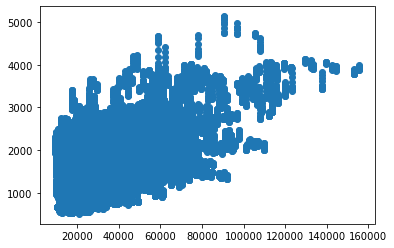

In [404]:
plt.scatter(train_X['income_per_capita'],train_y)

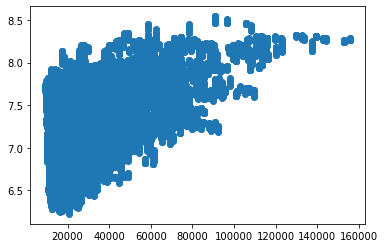

In [405]:
plt.scatter(train_X['income_per_capita'],np.log(train_y))

# LASSO

In [331]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

### Label Encode Zip, City, State

In [303]:
label_encoder_zip = LabelEncoder()
label_encoder_city = LabelEncoder()
label_encoder_state = LabelEncoder()

In [304]:
train_X['zip'] = label_encoder_zip.fit_transform(train_X['zip'])
train_X['City'] = label_encoder_city.fit_transform(train_X['City'])
train_X['State'] = label_encoder_state.fit_transform(train_X['State'])

In [305]:
test_X['zip'] = label_encoder_zip.transform(test_X['zip'])
test_X['City'] = label_encoder_city.transform(test_X['City'])
test_X['State'] = label_encoder_state.transform(test_X['State'])

In [306]:
set(train_X['zip']) == set(test_X['zip'])

True

### Standard Scaler

In [312]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [339]:
train_X

,zip,City,State,zri_lag1,zri_lag2,zri_lag3,percent_white,percent_black,percent_asian,percent_hispanic,...,percent_work_from_home_lag12,percent_work_from_home_lag24,median_age_lag12,median_age_lag24,percent_female_lag12,percent_female_lag24,gini_index_lag12,gini_index_lag24,percent_not_us_citizen_lag12,percent_not_us_citizen_lag24
0,0,84,15,0.0,0.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
1,0,84,15,928.0,0.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
2,0,84,15,931.0,928.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
3,0,84,15,934.0,931.0,928.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
4,0,84,15,929.0,934.0,931.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93655,1300,510,0,1332.0,1334.0,1335.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93656,1300,510,0,1337.0,1332.0,1334.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93657,1300,510,0,1337.0,1337.0,1332.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93658,1300,510,0,1335.0,1337.0,1337.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933


In [338]:
train_X_scaled

array([[-1.73072   , -1.18355718, -0.31120377, ..., -1.20353618,
        -1.06048559, -0.8097274 ],
       [-1.73072   , -1.18355718, -0.31120377, ..., -1.20353618,
        -1.06048559, -0.8097274 ],
       [-1.73072   , -1.18355718, -0.31120377, ..., -1.20353618,
        -1.06048559, -0.8097274 ],
       ...,
       [ 1.73072   ,  1.65706001, -1.49389929, ...,  0.50930001,
        -0.8044568 , -0.57071481],
       [ 1.73072   ,  1.65706001, -1.49389929, ...,  0.50930001,
        -0.8044568 , -0.57071481],
       [ 1.73072   ,  1.65706001, -1.49389929, ...,  0.50930001,
        -0.8044568 , -0.57071481]])

In [443]:
lasso = Lasso()
grid = dict()
grid['alpha'] = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

grid

{'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001, 0.01, 1, 5, 10]}

In [444]:
#clf = GridSearchCV(lasso, grid, cv=5, n_jobs=-1)

In [445]:
#lasso_grid = clf.fit(train_X_scaled,train_y)

In [446]:
lasso_grid.best_params_

{'alpha': 10}

In [447]:
lasso_grid.best_score_

0.8723623164261121

In [454]:
#lasso = lasso_grid.best_estimator_
lasso = Lasso(alpha=0.95)
lasso.fit(train_X_scaled, train_y)

Lasso(alpha=0.95)

In [455]:
lasso.fit(train_X_scaled, train_y)

Lasso(alpha=0.95)

In [456]:
print('LASSO')
print(f'R2: {lasso.score(test_X_scaled,test_y)}')
print(f'RMSE: {sqrt(mean_squared_error(lasso.predict(test_X_scaled),test_y))}')

LASSO
R2: 0.9845364738047435
RMSE: 82.7329513873741


# Feature importances (Non-zero coefficients )

In [457]:
importance = np.abs(lasso.coef_)
coef = lasso.coef_
feature_names = np.array(train_X.columns.to_list())

In [458]:
importance.shape

(111,)

In [459]:
feature_importances= pd.DataFrame([feature_names,importance,coef]).T
feature_importances.columns = ['feature_names','coef_abs','coef']

In [460]:
feature_importances = feature_importances.sort_values(by='coef_abs',ascending=False)
feature_importances[feature_importances['coef_abs']>0]

,feature_names,coef_abs,coef
3,zri_lag1,469.904548,469.904548
32,income_per_capita,102.73244,102.73244
5,zri_lag3,45.947818,45.947818
23,percent_commute_public_transport,39.158153,39.158153
2,State,34.323307,-34.323307
65,percent_graduate_deg_lag12,26.886471,-26.886471
8,percent_asian,25.869581,25.869581
16,percent_rental_units_vacant,25.660053,-25.660053
29,percent_new_unit,23.669399,-23.669399
40,percent_not_us_citizen,23.295909,23.295909


In [461]:
sfm = SelectFromModel(lasso).fit(train_X_scaled, train_y)
print("Features selected by SelectFromModel: \n"
      f"{feature_names[sfm.get_support()]}")

Features selected by SelectFromModel: 
['City' 'State' 'zri_lag1' 'zri_lag3' 'percent_white' 'percent_asian'
 'percent_hispanic' 'percent_native_am' 'percent_other_race'
 'percent_0_17' 'percent_40_64' 'percent_rental_units_vacant'
 'percent_graduate_deg' 'percent_bachelors' 'percent_associates'
 'percent_highschool' 'percent_commute_public_transport'
 'percent_commute_less_30' 'percent_commute_30_to_59'
 'percent_commute_90_more' 'percent_new_city' 'percent_new_unit'
 'percent_units_owner_occupied' 'median_building_age' 'income_per_capita'
 'total_pop' 'percent_work_from_home' 'percent_female' 'gini_index'
 'percent_not_us_citizen' 'percent_other_race_lag24'
 'percent_rental_units_vacant_lag12' 'percent_rental_units_vacant_lag24'
 'percent_graduate_deg_lag12' 'percent_graduate_deg_lag24'
 'percent_bachelors_lag12' 'percent_associates_lag24'
 'percent_highschool_lag12' 'percent_commute_public_transport_lag12'
 'percent_commute_60_to_89_lag12' 'percent_commute_90_more_lag24'
 'percent_n

In [462]:
feature_names[sfm.get_support()].shape

(45,)

In [463]:
zri

,zip,City,State,Metro,CountyName,year-month,zri,year
0,01013,Chicopee,MA,Springfield,Hampden County,2014-01-01,928.0,2014
1,01013,Chicopee,MA,Springfield,Hampden County,2014-02-01,931.0,2014
2,01013,Chicopee,MA,Springfield,Hampden County,2014-03-01,934.0,2014
3,01013,Chicopee,MA,Springfield,Hampden County,2014-04-01,929.0,2014
4,01013,Chicopee,MA,Springfield,Hampden County,2014-05-01,929.0,2014
...,...,...,...,...,...,...,...,...
93739,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-08-01,1277.0,2019
93740,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-09-01,1271.0,2019
93741,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-10-01,1299.0,2019
93742,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-11-01,1261.5,2019
